In [2]:
import sys

preprocessing_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Year 3\\COMP3200\\fake-news-profiling\\classifier\\preprocessing'
if preprocessing_path not in sys.path:
    sys.path.insert(1, preprocessing_path)

notif_path = 'C:\\Users\\joshh\\Desktop\\Uni\\Soton Year 3\\COMP3200\\fake-news-profiling\\classifier\\notifications'
if notif_path not in sys.path:
    sys.path.insert(1, notif_path)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import ipynb.fs.full.parse_datasets as datasets
import ipynb.fs.full.preprocessing as pp
import ipynb.fs.full.bert_fake_news_classifier as bclf
from ipynb.fs.full.notif_email import send_email

## Parse the dataset

In [4]:
tweet_data, label_data = datasets.parse_dataset("datasets", "en")

## Preprocess the data

In [5]:
# Preprocess the data
tweet_preprocessor = pp.TweetPreprocessor(
    preprocess_funcs = [
        pp.tag_indicators,
        pp.replace_xml_and_html,
        pp.replace_emojis,
        pp.remove_punctuation,
        pp.replace_tags,
        pp.remove_hashtag_chars,
        pp.replace_accented_chars,
        pp.tag_numbers,
        pp.remove_stopwords,
        pp.remove_extra_spacing,
    ])
tweet_preprocessor.preprocess(tweet_data)

In [6]:
tweet_data_individual = tweet_preprocessor.get_individual_tweets_dataset()
tweet_data_feed = tweet_preprocessor.get_tweet_feed_dataset()

In [7]:
# Split the data
(tweet_train, label_train, 
 tweet_val, label_val, 
 tweet_test, label_test) = datasets.split_dataset(tweet_data_individual, label_data)

## BERT Individual Model

In [8]:
small_bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1"
bert_encoder_individual = hub.KerasLayer(
    small_bert_url, 
    trainable=True,
)

bert_input_size_individual = 128

In [9]:
individual_tokenizer = bclf.BertIndividualTweetTokenizer(bert_encoder_individual, bert_input_size_individual)
bert_model_individual = bclf.create_bert_model(bert_encoder_individual, bert_input_size_individual)
bert_model_individual.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

In [10]:
# Create a checkpoint for training
checkpoint_path_individual = "training/bert_training_individual_1/cp.ckpt"

bert_checkpoint_callback_individual = ModelCheckpoint(
    filepath=checkpoint_path_individual,
    save_weights_only=True,
    verbose=1
)

In [11]:
tweet_individual_train = individual_tokenizer.tokenize_input(tweet_train)
label_individual_train = individual_tokenizer.tokenize_labels(label_train)
tweet_individual_val = individual_tokenizer.tokenize_input(tweet_val)
label_individual_val = individual_tokenizer.tokenize_labels(label_val)
tweet_individual_test = individual_tokenizer.tokenize_input(tweet_test)
label_individual_test = individual_tokenizer.tokenize_labels(label_test)

### Finding optimal hyper parameters (batch_size, epochs)

In [13]:
results = [{'batch_size': 1, 'epochs': 10, 'loss': 1.2027349472045898, 'accuracy': 0.570888876914978}, {'batch_size': 8, 'epochs': 10, 'loss': 0.8909910321235657, 'accuracy': 0.5973333120346069}, {'batch_size': 8, 'epochs': 50, 'loss': 2.1527915000915527, 'accuracy': 0.5951111316680908}, {'batch_size': 8, 'epochs': 100, 'loss': 2.6716349124908447, 'accuracy': 0.5737777948379517}, {'batch_size': 32, 'epochs': 10, 'loss': 0.8014382719993591, 'accuracy': 0.5855555534362793}, {'batch_size': 32, 'epochs': 50, 'loss': 1.791918396949768, 'accuracy': 0.5933333039283752}, {'batch_size': 32, 'epochs': 100, 'loss': 2.2307729721069336, 'accuracy': 0.5973333120346069}]
batch_sizes = [64]
epochs = [10, 50, 100]

for batch_size in batch_sizes:
    for epoch in epochs:

        # Fit the model and then evaluate
        with tf.device('gpu:0'):
            bert_encoder_individual_test = hub.KerasLayer(
                small_bert_url, 
                trainable=True,
            )
            bert_model_individual_test = clf.create_bert_model(bert_encoder_individual_test, bert_input_size_individual)
            bert_model_individual_test.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])
            
            bert_model_individual_test.fit(
                x=tweet_individual_train, 
                y=label_individual_train, 
                batch_size=batch_size, 
                epochs=epoch,
            )
            
            evaluated_results = bert_model_individual_test.evaluate(tweet_individual_val, label_individual_val)
            results.append({
                'batch_size': batch_size, 
                'epochs': epoch, 
                'loss': evaluated_results[0], 
                'accuracy': evaluated_results[1]
            })
            print(results[-1])

Epoch 1/10
329/329 [==============================] - 81s 246ms/step - loss: 0.6682 - accuracy: 0.5874
Epoch 2/10
329/329 [==============================] - 81s 247ms/step - loss: 0.6340 - accuracy: 0.6392
Epoch 3/10
329/329 [==============================] - 81s 247ms/step - loss: 0.6187 - accuracy: 0.6549
Epoch 4/10
329/329 [==============================] - 81s 247ms/step - loss: 0.5999 - accuracy: 0.6768
Epoch 5/10
329/329 [==============================] - 81s 247ms/step - loss: 0.5834 - accuracy: 0.6926
Epoch 6/10
329/329 [==============================] - 81s 247ms/step - loss: 0.5652 - accuracy: 0.7097
Epoch 7/10
329/329 [==============================] - 81s 246ms/step - loss: 0.5473 - accuracy: 0.7217
Epoch 8/10
329/329 [==============================] - 81s 247ms/step - loss: 0.5304 - accuracy: 0.7325
Epoch 9/10
329/329 [==============================] - 81s 247ms/step - loss: 0.5142 - accuracy: 0.7476
Epoch 10/10
141/141 [==============================] - 6s 42ms/step - los

329/329 [==============================] - 81s 247ms/step - loss: 0.0514 - accuracy: 0.9796
Epoch 95/100
329/329 [==============================] - 81s 247ms/step - loss: 0.0529 - accuracy: 0.9806
Epoch 96/100
329/329 [==============================] - 81s 247ms/step - loss: 0.0484 - accuracy: 0.9811
Epoch 97/100
329/329 [==============================] - 81s 247ms/step - loss: 0.0541 - accuracy: 0.9789
Epoch 98/100
329/329 [==============================] - 81s 247ms/step - loss: 0.0518 - accuracy: 0.9798
Epoch 99/100
329/329 [==============================] - 81s 247ms/step - loss: 0.0523 - accuracy: 0.9791
Epoch 100/100
141/141 [==============================] - 6s 42ms/step - loss: 2.0028 - accuracy: 0.6007
{'batch_size': 64, 'epochs': 100, 'loss': 2.0028185844421387, 'accuracy': 0.6006666421890259}


In [21]:
best_result = max(results, key=lambda result: result['accuracy'])
best_result

{'batch_size': 64,
 'epochs': 10,
 'loss': 0.725799024105072,
 'accuracy': 0.6437777876853943}

In [15]:
send_email(
    f"""
    Grid Search finished.
    Best model: 
    > batch_size: {best_result['batch_size']}
    > epochs: {best_result['epochs']}
    > loss: {best_result['loss']}
    > accuracy: {best_result['accuracy']}
    
    All results: {results}
    
    Now training model.
    """)

In [ ]:
results = [{'batch_size': 1,
  'epochs': 10,
  'loss': 1.2027349472045898,
  'accuracy': 0.570888876914978},
 {'batch_size': 8,
  'epochs': 10,
  'loss': 0.8909910321235657,
  'accuracy': 0.5973333120346069},
 {'batch_size': 8,
  'epochs': 50,
  'loss': 2.1527915000915527,
  'accuracy': 0.5951111316680908},
 {'batch_size': 8,
  'epochs': 100,
  'loss': 2.6716349124908447,
  'accuracy': 0.5737777948379517},
 {'batch_size': 32,
  'epochs': 10,
  'loss': 0.8014382719993591,
  'accuracy': 0.5855555534362793},
 {'batch_size': 32,
  'epochs': 50,
  'loss': 1.791918396949768,
  'accuracy': 0.5933333039283752},
 {'batch_size': 32,
  'epochs': 100,
  'loss': 2.2307729721069336,
  'accuracy': 0.5973333120346069},
 {'batch_size': 64,
  'epochs': 10,
  'loss': 0.725799024105072,
  'accuracy': 0.6437777876853943},
 {'batch_size': 64,
  'epochs': 50,
  'loss': 1.4171788692474365,
  'accuracy': 0.6006666421890259},
 {'batch_size': 64,
  'epochs': 100,
  'loss': 2.0028185844421387,
  'accuracy': 0.6006666421890259}]

#### Fitting with optimal parameters

In [16]:
with tf.device('gpu:0'):
    # Fit
    bert_model_individual.fit(
        x=tweet_individual_train, 
        y=label_individual_train, 
        batch_size=best_result['batch_size'], 
        epochs=best_result['epochs'], 
        callbacks=[bert_checkpoint_callback_individual],
        validation_data=(tweet_individual_val, label_individual_val),
    )

Epoch 1/10
328/329 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.6004
Epoch 00001: saving model to training/bert_training_individual_1\cp.ckpt
329/329 [==============================] - 88s 266ms/step - loss: 0.6594 - accuracy: 0.6003 - val_loss: 0.6572 - val_accuracy: 0.6369
Epoch 2/10
328/329 [============================>.] - ETA: 0s - loss: 0.6308 - accuracy: 0.6431
Epoch 00002: saving model to training/bert_training_individual_1\cp.ckpt
329/329 [==============================] - 87s 265ms/step - loss: 0.6309 - accuracy: 0.6430 - val_loss: 0.6558 - val_accuracy: 0.6418
Epoch 3/10
328/329 [============================>.] - ETA: 0s - loss: 0.6128 - accuracy: 0.6644
Epoch 00003: saving model to training/bert_training_individual_1\cp.ckpt
329/329 [==============================] - 87s 265ms/step - loss: 0.6129 - accuracy: 0.6643 - val_loss: 0.6577 - val_accuracy: 0.6456
Epoch 4/10
328/329 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.

In [17]:
eval_result = bert_model_individual.evaluate(tweet_individual_test, label_individual_test)

141/141 [==============================] - 6s 42ms/step - loss: 0.7464 - accuracy: 0.5804


In [18]:
send_email(
    f"""
    Individual model fit finished.
    > loss: {eval_result[0]}
    > accuracy: {eval_result[1]}
    """)

### Evaluating for each user (rather than each tweet)

In [11]:
# Calculate user predictions from individual tweet data
def calculate_user_predictions_from_individual_tweets(model, tweets, labels):
    # Get tweets for each user
    tweets_per_user = 100
    user_tweets = [
        {
            'input_word_ids': tweets['input_word_ids'][i:i+tweets_per_user],
            'input_mask': tweets['input_mask'][i:i+tweets_per_user],
            'input_type_ids': tweets['input_type_ids'][i:i+tweets_per_user],
        }
        for i in range(0, len(tweets['input_word_ids']), tweets_per_user)
    ]
    user_labels = np.asarray([
        labels[i].numpy() for i in range(0, len(labels), tweets_per_user)
     ])
    
    # Evaluate each user
    all_predictions = []
    for user_label, user_tweet in zip(user_labels, user_tweets):
        all_predictions.append(
            model.predict(user_tweet).flatten()
        )
    
    return np.asarray(all_predictions), user_labels

In [12]:
def is_true_positive(label, prediction):
    return label == 1 and prediction == 1
    
def is_false_positive(label, prediction):
    return label == 0 and prediction == 1

def is_false_negative(label, prediction):
    return label == 1 and prediction == 0 
    
def is_true_negative(label, prediction):
    return label == 0 and prediction == 0

# Evaluate the model, returning accuracy, recall, f1, etc
# predictions should be of type [(label, [predictions])]
def evaluate_model(predictions, labels):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for prediction, label in zip(predictions, labels):
        # Take the mean of the users predictions and compare to threshold
        if is_true_positive(label, prediction):
            tp += 1
        elif is_false_positive(label, prediction):
            fp += 1
        elif is_false_negative(label, prediction):
            fn += 1
        elif is_true_negative(label, prediction):
            tn += 1
        else:
            print("Error:", label, prediction)
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else float("NaN")
    recall = tp / (tp + fn) if (tp + fn) > 0 else float("NaN")
    f1 = 2 * (precision * recall) / (precision + recall) if precision > 0 and recall > 0 else float("NaN")
            
    return {
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'true_negatives': tn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [98]:
def create_test_model(trainable=True):
    bert_encoder_individual_test = hub.KerasLayer(
        small_bert_url, 
        trainable=trainable,
    )
    bert_model_individual_test = bclf.create_bert_model(bert_encoder_individual_test, bert_input_size_individual)
    bert_model_individual_test.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])
    return bert_encoder_individual_test, bert_model_individual_test

In [95]:
# Train and save best individual models
pairs = [(8, 10), (32, 100), (64, 10)]

for batch_size, epoch in pairs:
    with tf.device('gpu:0'):
        # Create checkpoint
        checkpoint = ModelCheckpoint(
            filepath=f"training/bert_individual/batch{batch_size}-epoch{epoch}-2/cp.ckpt",
            save_weights_only=True,
            verbose=1
        )
        
        # Create model
        bert_encoder_individual_test = hub.KerasLayer(
            small_bert_url, 
            trainable=True,
        )
        bert_model_individual_test = bclf.create_bert_model(bert_encoder_individual_test, bert_input_size_individual)
        bert_model_individual_test.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

        bert_model_individual_test.fit(
            x=tweet_individual_train, 
            y=label_individual_train, 
            batch_size=batch_size, 
            epochs=epoch, 
            callbacks=[checkpoint],
        )

Epoch 1/10
   1/2625 [..............................] - ETA: 1:10 - loss: 0.6308 - accuracy: 0.7500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0290s). Check your callbacks.


2625/2625 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.6153
Epoch 00001: saving model to training/bert_individual/batch8-epoch10-2\cp.ckpt
2625/2625 [==============================] - 107s 41ms/step - loss: 0.6508 - accuracy: 0.6153
Epoch 2/10
2625/2625 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.6673
Epoch 00002: saving model to training/bert_individual/batch8-epoch10-2\cp.ckpt
2625/2625 [==============================] - 108s 41ms/step - loss: 0.6046 - accuracy: 0.6673
Epoch 3/10
2625/2625 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7029
Epoch 00003: saving model to training/bert_individual/batch8-epoch10-2\cp.ckpt
2625/2625 [==============================] - 107s 41ms/step - loss: 0.5679 - accuracy: 0.7029
Epoch 4/10
2625/2625 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7358
Epoch 00004: saving model to training/bert_individual/batch8-epoch10-2\cp.ckpt
2625/2625 [==========

656/657 [============================>.] - ETA: 0s - loss: 0.0753 - accuracy: 0.9708
Epoch 00051: saving model to training/bert_individual/batch32-epoch100-2\cp.ckpt
657/657 [==============================] - 87s 132ms/step - loss: 0.0753 - accuracy: 0.9708
Epoch 52/100
656/657 [============================>.] - ETA: 0s - loss: 0.0790 - accuracy: 0.9698
Epoch 00052: saving model to training/bert_individual/batch32-epoch100-2\cp.ckpt
657/657 [==============================] - 87s 132ms/step - loss: 0.0790 - accuracy: 0.9698
Epoch 53/100
656/657 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.9726
Epoch 00053: saving model to training/bert_individual/batch32-epoch100-2\cp.ckpt
657/657 [==============================] - 87s 132ms/step - loss: 0.0745 - accuracy: 0.9726
Epoch 54/100
656/657 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9737
Epoch 00054: saving model to training/bert_individual/batch32-epoch100-2\cp.ckpt
657/657 [============

In [154]:
send_email("Finished training")

#### Classifying BERT predictions

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [96]:
def train_classifier(clf, X_train, y_train, X_val, y_val, batch_size, epochs):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_val)
    return {
        'batch_size': batch_size,
        'epochs': epochs,
        'predictions_val': predictions,
        'labels_val': y_val,
    }

In [99]:
pairs = [(8, 10), (32, 100), (64, 10)]
predictions = {
    'logistic_regression': [],
    'logistic_regression_sorted': [],
    'svm': [],
    'svm_sorted': [],
}

for batch_size, epoch in pairs:
    # Load the BERT model
    print(f"Loading weights for batch_size:{batch_size}, epochs: {epoch}")
    encoder, model = create_test_model(trainable=False)
    model.load_weights(
        f"training/bert_individual/batch{batch_size}-epoch{epoch}-2/cp.ckpt"
    ).expect_partial()
    
    # Predict training and validation set data
    X_train, y_train = calculate_user_predictions_from_individual_tweets(
        model, 
        tweet_individual_train, 
        label_individual_train,
    )
    X_val, y_val = calculate_user_predictions_from_individual_tweets(
        model, 
        tweet_individual_val, 
        label_individual_val,
    )
    
    # Train Logistic Regression model
    print("Training LR")
    predictions['logistic_regression'].append(
        train_classifier(
            LogisticRegression(), 
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            batch_size, 
            epoch
        )
    )
    
    # Train Logistic Regression when training data sorted
    print("Training LR sorted")
    X_train_sorted = np.sort(X_train, axis=1)
    X_val_sorted = np.sort(X_val, axis=1)
    predictions['logistic_regression_sorted'].append(
        train_classifier(
            LogisticRegression(), 
            X_train_sorted, 
            y_train, 
            X_val_sorted, 
            y_val, 
            batch_size, 
            epoch
        )
    )

    # Train SVM model
    print("Training SVM")
    predictions['svm'].append(
        train_classifier(
            SVC(probability=True), 
            X_train, 
            y_train, 
            X_val, 
            y_val, 
            batch_size, 
            epoch
        )
    )

    # Train SVM when training data sorted
    print("Training SVM sorted")
    predictions['svm_sorted'].append(
        train_classifier(
            SVC(probability=True), 
            X_train_sorted, 
            y_train, 
            X_val_sorted, 
            y_val, 
            batch_size, 
            epoch
        )
    )

Loading weights for batch_size:8, epochs: 10
Training LR
Training LR sorted
Training SVM
Training SVM sorted
Loading weights for batch_size:32, epochs: 100
Training LR
Training LR sorted
Training SVM
Training SVM sorted
Loading weights for batch_size:64, epochs: 10
Training LR
Training LR sorted
Training SVM
Training SVM sorted


In [47]:
send_email(f"Finished training, predictions:\n{predictions}")
predictions

{'logistic_regression': [{'batch_size': 8,
   'epochs': 10,
   'predictions_val': array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
          1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
          1]),
   'labels_val': array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
          1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
          1])},
  {'batch_size': 32,
   'epochs': 100,
   'predictions_val': array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
          1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
          1]),
   'labels_val': array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
          1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
          1])},
  {'batch_size': 64,
   'epochs': 10,
   'predictions_val': array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
          1, 1, 0, 0, 1, 0, 1, 1

In [100]:
import pandas as pd

results = []
for key, val in predictions.items():
    for clf_info in val:
        res = []
        res.append(key)
        res.append(clf_info['batch_size'])
        res.append(clf_info['epochs'])
        
        eval_scores = evaluate_model(
            clf_info['predictions_val'], 
            clf_info['labels_val']
        )
        res.append(eval_scores['accuracy'])
        res.append(eval_scores['precision'])
        res.append(eval_scores['recall'])
        res.append(eval_scores['f1'])
        results.append(res)

df = pd.DataFrame(results, columns=['final classifier', 'batch_size', 'epochs', 'accuracy', 'precision', 'recall', 'f1'])

In [101]:
df.sort_values(by=['accuracy', 'f1'], ascending=False)

,final classifier,batch_size,epochs,accuracy,precision,recall,f1
1,logistic_regression,32,100,0.777778,0.750000,0.875000,0.807692
9,svm_sorted,8,10,0.755556,0.782609,0.750000,0.765957
7,svm,32,100,0.733333,0.772727,0.708333,0.739130
4,logistic_regression_sorted,32,100,0.711111,0.720000,0.750000,0.734694
2,logistic_regression,64,10,0.711111,0.739130,0.708333,0.723404
10,svm_sorted,32,100,0.711111,0.739130,0.708333,0.723404
0,logistic_regression,8,10,0.711111,0.761905,0.666667,0.711111
3,logistic_regression_sorted,8,10,0.711111,0.761905,0.666667,0.711111
8,svm,64,10,0.711111,0.789474,0.625000,0.697674
5,logistic_regression_sorted,64,10,0.711111,0.823529,0.583333,0.682927


In [ ]:
send_email("Finished")

#### Predict the probability of a user being a fake news spreader

In [31]:
# Load the BERT model
print(f"Loading weights for batch_size: 32, epochs: 100")
encoder, model = create_test_model()
model.load_weights(
    f"training/bert_individual/batch32-epoch100/cp.ckpt"
).expect_partial()

# Predict training and validation set data
X_train, y_train = calculate_user_predictions_from_individual_tweets(
    model, 
    tweet_individual_train, 
    label_individual_train,
)
X_val, y_val = calculate_user_predictions_from_individual_tweets(
    model, 
    tweet_individual_val, 
    label_individual_val,
)

# Train Logistic Regression model
print("Training LR")
log_reg_clf = LogisticRegression()
log_reg_clf.fit(X_train, y_train)

# Train SVM
print("Training SVM")
svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)

# Train Logistic Regression when training data sorted
print("Training LR sorted")
X_train_sorted = np.sort(X_train, axis=1)
X_val_sorted = np.sort(X_val, axis=1)
log_reg_sorted_clf = LogisticRegression()
log_reg_sorted_clf.fit(X_train_sorted, y_train)

Loading weights for batch_size: 32, epochs: 100


Training LR
Training SVM
Training LR sorted


LogisticRegression()

In [32]:
print("LR User 1 predict probability:", 
      log_reg_clf.predict_proba([X_val[0]]))
print("LR User 1 prediction:", log_reg_clf.predict([X_val[0]]))
print("LR sorted User 1 predict probability:", 
      log_reg_sorted_clf.predict_proba([X_val_sorted[0]]))
print("LR sorted User 1 prediction:", log_reg_sorted_clf.predict([X_val_sorted[0]]))
print("SVM User 1 predict probability:", 

      svm_clf.predict_proba([X_val[0]]))
print("SVM User 1 prediction:", svm_clf.predict([X_val[0]]))
print("User 1 label:", y_val[0])

LR User 1 predict probability: [[0.52118894 0.47881106]]
LR User 1 prediction: [0]
LR sorted User 1 predict probability: [[0.74938058 0.25061942]]
LR sorted User 1 prediction: [0]
SVM User 1 predict probability: [[0.792287 0.207713]]
SVM User 1 prediction: [0]
User 1 label: 0


### Training BERT individual + Logistic Regression sorted
BERT Model:
* BERT L-12, Input 128
* Individual tweets
* batch_size 32, epochs 100

Logistic Regression Model:
* Predict training set using BERT and sort each datapoint - this will be the LR training data
* Logistic Regression

In [88]:
import ipynb.fs.full.bert_fake_news_classifier as bclf

# Encoder
bert_individual_size = 128
bert_individual_encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1", 
    trainable=True,
)

# Model
individual_tokenizer = bclf.BertIndividualTweetTokenizer(
    bert_individual_encoder, 
    bert_individual_size,
)
bert_individual_model = bclf.create_bert_model(
    bert_individual_encoder, 
    bert_individual_size,
)
bert_individual_model.compile(
    Adam(lr=1e-5), 
    'binary_crossentropy', 
    ['accuracy']
)

# Checkpoint
checkpoint_path_individual = "training/bert_individual/best-batch_size32-epochs-100-2/bert/cp.ckpt"
bert_individual_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path_individual,
    save_weights_only=True,
    verbose=1
)

In [89]:
# Train BERT
bert_individual_model.fit(
    x=tweet_individual_train,
    y=label_individual_train,
    batch_size=32,
    epochs=100,
    callbacks=[bert_individual_checkpoint_callback],
)

Epoch 1/100
656/657 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.5928
Epoch 00001: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.6654 - accuracy: 0.5927
Epoch 2/100
656/657 [============================>.] - ETA: 0s - loss: 0.6331 - accuracy: 0.6413
Epoch 00002: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.6332 - accuracy: 0.6412
Epoch 3/100
656/657 [============================>.] - ETA: 0s - loss: 0.6054 - accuracy: 0.6687
Epoch 00003: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.6053 - accuracy: 0.6687
Epoch 4/100
656/657 [============================>.] - ETA: 0s - loss: 0.5824 - accuracy: 0.6915
Epoch 00004: saving model to training/bert

657/657 [==============================] - 89s 135ms/step - loss: 0.1957 - accuracy: 0.9199
Epoch 30/100
656/657 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9220
Epoch 00030: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.1903 - accuracy: 0.9220
Epoch 31/100
656/657 [============================>.] - ETA: 0s - loss: 0.1818 - accuracy: 0.9259
Epoch 00031: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.1817 - accuracy: 0.9260
Epoch 32/100
656/657 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9322
Epoch 00032: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.1702 - accuracy: 0.9322
Epoch 33/100
656/657 [======================

657/657 [==============================] - 88s 134ms/step - loss: 0.0346 - accuracy: 0.9863
Epoch 87/100
656/657 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9874
Epoch 00087: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.0342 - accuracy: 0.9874
Epoch 88/100
656/657 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9876
Epoch 00088: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.0338 - accuracy: 0.9876
Epoch 89/100
656/657 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9880
Epoch 00089: saving model to training/bert_individual/best-batch_size32-epochs-100-2/bert\cp.ckpt
657/657 [==============================] - 88s 134ms/step - loss: 0.0320 - accuracy: 0.9880
Epoch 90/100
656/657 [======================

In [93]:
bert_individual_model.evaluate(tweet_individual_val, label_individual_val)

141/141 [==============================] - 6s 42ms/step - loss: 2.2917 - accuracy: 0.5707


[2.2916836738586426, 0.5706666707992554]

In [84]:
# bert_individual_model = bclf.create_bert_model(
#     bert_individual_encoder, 
#     bert_individual_size,
# )
# bert_individual_model.load_weights(
#     f"training/bert_individual/batch32-epoch100/cp.ckpt"
# ).expect_partial()

In [90]:
from joblib import dump, load

# Train Logistic Regression classifier
X_train, y_train = calculate_user_predictions_from_individual_tweets(
    bert_individual_model, 
    tweet_individual_train, 
    label_individual_train,
)
X_train_sorted = np.sort(X_train, axis=1)

clf = LogisticRegression()
clf.fit(X_train_sorted, y_train)
dump(clf, "training/bert_individual/best-batch_size32-epochs-100-2/logistic_regressor.joblib") 

['training/bert_individual/best-batch_size32-epochs-100-2/logistic_regressor.joblib']

In [91]:
clf = load("training/bert_individual/best-batch_size32-epochs-100-2/logistic_regressor.joblib") 

In [92]:
# Evaluate the model
X_val, y_val = calculate_user_predictions_from_individual_tweets(
    bert_individual_model, 
    tweet_individual_val, 
    label_individual_val,
)
X_val_sorted = np.sort(X_val, axis=1)

X_test, y_test = calculate_user_predictions_from_individual_tweets(
    bert_individual_model, 
    tweet_individual_test, 
    label_individual_test,
)
X_test_sorted = np.sort(X_test, axis=1)

pred_val = clf.predict(X_val_sorted)
pred_test = clf.predict(X_test_sorted)

result = f"Validation eval:\n{evaluate_model(pred_val, y_val)}\nTest eval:\n{evaluate_model(pred_test, y_test)}"
send_email(result)
print(result)

Validation eval:
{'true_positives': 19, 'false_positives': 8, 'false_negatives': 5, 'true_negatives': 13, 'accuracy': 0.7111111111111111, 'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1': 0.7450980392156864}
Test eval:
{'true_positives': 14, 'false_positives': 12, 'false_negatives': 4, 'true_negatives': 15, 'accuracy': 0.6444444444444445, 'precision': 0.5384615384615384, 'recall': 0.7777777777777778, 'f1': 0.6363636363636364}


## BERT Tweet Feed Model

In [ ]:
medium_bert_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1"
bert_encoder_feed = hub.KerasLayer(
    medium_bert_url, 
    trainable=True,
)

bert_input_size_feed = 500

In [ ]:
feed_tokenizer = clf.BertTweetFeedTokenizer(bert_encoder_feed, bert_input_size_feed)
bert_model_feed = bclf.create_bert_model(bert_encoder_feed, bert_input_size_feed)
bert_model_feed.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

### Training

In [ ]:
# Create a checkpoint for training
checkpoint_path_feed = "training/bert_training_feed_2/cp.ckpt"

bert_checkpoint_callback_feed = ModelCheckpoint(
    filepath=checkpoint_path_feed,
    save_weights_only=True,
    verbose=1
)

In [ ]:
tweet_feed_train = feed_tokenizer.tokenize_input(tweet_train)
label_feed_train = feed_tokenizer.tokenize_labels(label_train)
tweet_feed_val = feed_tokenizer.tokenize_input(tweet_val)
label_feed_val = feed_tokenizer.tokenize_labels(label_val)
tweet_feed_test = feed_tokenizer.tokenize_input(tweet_test)
label_feed_test = feed_tokenizer.tokenize_labels(label_test)

In [ ]:
with tf.device('gpu:0'):
    # Fit
    bert_model_feed.fit(
        x=tweet_feed_train, 
        y=label_feed_train, 
        batch_size=10, 
        epochs=5, 
        callbacks=[bert_checkpoint_callback_feed], 
        validation_data=(tweet_feed_val, label_feed_val),
    )

In [12]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from official.nlp.bert.tokenization import FullTokenizer

In [90]:
def create_bert_model_2(encoder, input_size=128, num_tweets=100):
    input_layer = Input(shape=(num_tweets, 3, input_size), dtype=tf.int32) # (100, 3, 128)

    dense = Dense(1, activation='sigmoid')
    def inner(inner_inputs):
        encoder_pooled_output = encoder(inner_inputs)['pooled_output']
        dense_output = dense(encoder_pooled_output)
        return dense_output
    
    combined = tf.keras.layers.concatenate([inner({
        'input_word_ids': input_layer[:0, i, 0],
        'input_mask': input_layer[:0, i, 1],
        'input_type_ids': input_layer[:0, i, 2],
    }) for i in range(num_tweets)])
    
    softmax_output = Dense(1, activation='softmax')(combined)

    # Create the Keras model and compile
    return Model(input_layer, softmax_output)

In [88]:
bert_model_2 = create_bert_model_2(bert_encoder_individual, input_size=128, num_tweets=5)
bert_model_2.compile(Adam(lr=1e-5), 'binary_crossentropy', ['accuracy'])

hi
Tensor("input_32:0", shape=(None, 5, 3, 128), dtype=int32)


In [13]:
x_copy = tweet_individual_val
x_copy_re = tf.convert_to_tensor([[
    [x_copy['input_word_ids'][j*i],
    x_copy['input_mask'][j*i],
    x_copy['input_type_ids'][j*i],]
    for j in range(100)
] for i in range(45)])

y_copy = label_individual_val
y_copy_re = tf.convert_to_tensor([label_individual_val.numpy()[i] for i in range(0, 4500, 100)])

In [ ]:
with tf.device('gpu:0'):
    bert_model_2.fit(
        x=x_copy_re[0:3, :5],
        y=y_copy_re[0:3],
        batch_size=32,
        epochs=1,
    )

In [85]:
bert_model_2.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 5, 3, 128)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_335 ( [(None, 128)]        0           input_31[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_336 ( [(None, 128)]        0           input_31[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_334 ( [(None, 128)]        0           input_31[0][0]                   
_______________________________________________________________________________________

In [25]:
# COPIED FROM https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
bert_model = bclf.create_bert_model(bert_encoder_individual, 128)
bert_optimizer = Adam(lr=1e-5)
bert_loss_fn = tf.keras.losses.BinaryCrossentropy()

In [26]:
def create_clf_model():
    input_layer = Input(shape=(100,))
    dense_out = Dense(1, activation="sigmoid")(input_layer)
    return tf.keras.Model(inputs=input_layer, outputs=dense_out)

clf_model = create_clf_model()
clf_optimizer = Adam(lr=1e-5)
clf_loss_fn = tf.keras.losses.BinaryCrossentropy()
clf_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
clf_val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_copy_re, y_copy_re))
train_dataset = train_dataset.batch(6) # users per batch
train_dataset

<BatchDataset shapes: ((None, 100, 3, 128), (None,)), types: (tf.int32, tf.int32)>

In [56]:
def tweets_to_bert_batch(tweets_batch):
    res = {
        'input_word_ids': tweets_batch[:, 0],
        'input_mask': tweets_batch[:, 1],
        'input_type_ids': tweets_batch[:, 2],
    }
    return res

def to_tweet_batches(x_train, num_tweets, tweet_batch_size):
    return [
        tweets_to_bert_batch(x_train[i:i+tweet_batch_size]) 
        for i in range(0, num_tweets, tweet_batch_size)
    ]

def train_step(x_batch_train, y_batch_train, num_tweets=100, tweet_batch_size=20):
    with tf.GradientTape(watch_accessed_variables=False) as bert_tape, tf.GradientTape(watch_accessed_variables=False) as clf_tape:
        bert_tape.watch(bert_model.variables)
        bert_tape.watch(clf_model.variables)
        clf_tape.watch(clf_model.variables)
        
        clf_batch_logits = []

        # For each user in the batch
        for x_user_train in x_batch_train:

            # Predict tweet batches using BERT
            bert_user_logits = tf.convert_to_tensor([])

            for tweet_batch in to_tweet_batches(x_user_train, num_tweets, tweet_batch_size):
                bert_batch_logits = tf.reshape(
                    bert_model(tweet_batch, training=True), 
                    shape=(-1,),
                )
                bert_user_logits = tf.concat(
                    (bert_user_logits, bert_batch_logits), 
                    axis=0,
                )

            # Predict using Classifier
            clf_inputs = tf.reshape(bert_user_logits, shape=(1, -1))
            clf_logits = clf_model(clf_inputs, training=True)
            clf_batch_logits.append(clf_logits)

        # Take the loss of entire batch
        clf_batch_logits_concat = tf.concat((clf_batch_logits), axis=0)

        y_batch_train = tf.reshape(y_batch_train, shape=(-1, 1))
        clf_batch_loss = clf_loss_fn(y_batch_train, clf_batch_logits_concat)

    # Update gradients after batch
    bert_grads = bert_tape.gradient(clf_batch_loss, bert_model.trainable_weights)
    bert_optimizer.apply_gradients(zip(bert_grads, bert_model.trainable_weights))

    clf_grads = clf_tape.gradient(clf_batch_loss, clf_model.trainable_weights)
    clf_optimizer.apply_gradients(zip(clf_grads, clf_model.trainable_weights))

    # Update training metric
    clf_train_acc_metric.update_state(y_batch_train, clf_batch_logits_concat)
    
    # Return batch loss
    return clf_batch_loss

In [57]:
# Modified FROM https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
import time

total_loss = []

with tf.device('cpu:0'):
    epochs = 10
    for epoch in range(epochs):
        print(f"\nEpoch {epoch}/{epochs}")
        epoch_loss = []

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            batch_loss = train_step(x_batch_train, y_batch_train)
            epoch_loss.append(batch_loss)
            print(f"> Batch {step}: loss={batch_loss}, accuracy={clf_train_acc_metric.result()}")
        
        print("Training acc over epoch: %.4f" % (float(clf_train_acc_metric.result()),))

        # Reset training metrics at the end of each epoch
        clf_train_acc_metric.reset_states()
        total_loss.append(epoch_loss)


Epoch 0/10


> Batch 0: loss=0.7131641507148743, accuracy=0.4888888895511627


> Batch 1: loss=0.7168457508087158, accuracy=0.4901960790157318


> Batch 2: loss=0.7257969975471497, accuracy=0.4912280738353729


> Batch 3: loss=0.6994034647941589, accuracy=0.4920634925365448


> Batch 4: loss=0.5383312702178955, accuracy=0.5362318754196167
> Batch 5: loss=0.6871833801269531, accuracy=0.5333333611488342
> Batch 6: loss=0.7790965437889099, accuracy=0.5185185074806213


KeyboardInterrupt: 

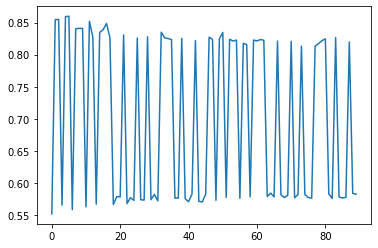

In [54]:
plt.plot(np.arange(0, 90, 1), total_loss)

In [141]:
bert_model.input_shape

{'input_word_ids': (None, 128),
 'input_mask': (None, 128),
 'input_type_ids': (None, 128)}